# ** Playing with GAN inversion and manipulation **



We will use StyleGAN-XL (which is a successor of StyleGAN) to invert an image to its latent space.

Then, after finding the latent code, you could manipulate it with text-guidance (with CLIP).

There are 4 parts

Part 1 - installing all the necessary libraries, and choosing the image that you will invert and manipulate

Part 2 - understanding how to use the GAN

Part 3 - main part - inverting your image.

Part 4 - manipulating your image with text-guidance.


### Credits and Links
This notebook is based on [this StyleGANXL+CLIP notebook](https://github.com/CasualGANPapers/StyleGANXL-CLIP) and [this notebook](https://github.com/CasualGANPapers/unconditional-StyleGAN-CLIP) which is a fork from the original notebook [here](https://colab.research.google.com/github/CasualGANPapers/unconditional-StyleGANXL-CLIP/blob/main/StyleganXL%2BCLIP.ipynb). Largely based on code by  [Katherine Crowson](https://github.com/crowsonkb) and [nshepperd](https://github.com/nshepperd). Mostly made possible because of [StyleGAN-XL](https://github.com/autonomousvision/stylegan_xl) and [CLIP](https://github.com/openai/CLIP). Created by [Eugenio Herrera](https://github.com/ouhenio) and [Rodrigo Mello](https://github.com/ryudrigo).


# Part 1 (Installation, Model selection and uploading your Image)

In [1]:
#@markdown #**Install libraries and define functions** 🏗️🛠️
# @markdown This cell will take a little while because it has to download several libraries.

#@markdown ---

!git clone https://github.com/autonomousvision/stylegan_xl
!git clone https://github.com/openai/CLIP
!git clone https://github.com/crowsonkb/esgd.git
!pip install -e ./CLIP
!pip install einops ninja
!pip install timm==0.5.4
!pip install dill
!pip install lpips
## I'll probably have to trim stuff here

import sys
sys.path.append('./CLIP')
sys.path.append('./stylegan_xl')
sys.path.append('./esgd')

import io
import os, time, glob
import pickle
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import clip
import unicodedata
import re
from esgd import ESGD
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from google.colab import files
import dnnlib
import legacy


device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

# Functions (many must be trimmed too)

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def fetch_model(url_or_path):
    !wget -c '{url_or_path}'

def slugify(value, allow_unicode=False):
    """
    Taken from https://github.com/django/django/blob/master/django/utils/text.py
    Convert to ASCII if 'allow_unicode' is False. Convert spaces or repeated
    dashes to single dashes. Remove characters that aren't alphanumerics,
    underscores, or hyphens. Convert to lowercase. Also strip leading and
    trailing whitespace, dashes, and underscores.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

def norm1(prompt):
    "Normalize to the unit sphere."
    return prompt / prompt.square().sum(dim=-1,keepdim=True).sqrt()

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

def prompts_dist_loss(x, targets, loss):
    if len(targets) == 1: # Keeps consitent results vs previous method for single objective guidance
      return loss(x, targets[0])
    distances = [loss(x, target) for target in targets]
    return torch.stack(distances, dim=-1).sum(dim=-1)

class MakeCutouts(torch.nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)

make_cutouts = MakeCutouts(224, 32, 0.5)

def embed_image(image):
  n = image.shape[0]
  cutouts = make_cutouts(image)
  embeds = clip_model.embed_cutout(cutouts)
  embeds = rearrange(embeds, '(cc n) c -> cc n c', n=n)
  return embeds

def embed_url(url):
  image = Image.open(fetch(url)).convert('RGB')
  return embed_image(TF.to_tensor(image).to(device).unsqueeze(0)).mean(0).squeeze(0)

class CLIP(object):
  def __init__(self):
    clip_model = "ViT-B/16"
    self.model, _ = clip.load(clip_model)
    self.model = self.model.requires_grad_(False)
    self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                          std=[0.26862954, 0.26130258, 0.27577711])

  @torch.no_grad()
  def embed_text(self, prompt):
      "Normalized clip text embedding."
      return norm1(self.model.encode_text(clip.tokenize(prompt).to(device)).float())

  def embed_cutout(self, image):
      "Normalized clip image embedding."
      return norm1(self.model.encode_image(self.normalize(image)))

clip_model = CLIP()

Cloning into 'stylegan_xl'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 298 (delta 74), reused 51 (delta 51), pack-reused 209
Receiving objects: 100% (298/298), 13.88 MiB | 821.00 KiB/s, done.
Resolving deltas: 100% (141/141), done.
Cloning into 'CLIP'...
remote: Enumerating objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 8.92 MiB | 3.19 MiB/s, done.
Resolving deltas: 100% (124/124), done.
Cloning into 'esgd'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 43 (delta 16), reused 41 (delta 14), pack-reused 0
Unpacking objects: 100% (43/43), 10.46 KiB | 974.00 KiB/s, done.
Obtaining file:///content/CLIP
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.0 MB/s e

Using device: cuda:0
100%|███████████████████████████████████████| 335M/335M [00:08<00:00, 42.4MiB/s]


In [2]:
#@markdown #**Model selection** 🎭

#@markdown This will install a pre-trained GAN from the list here.
#@markdown It's better to start with the FFHQ that was trained on faces
#@markdown with 256 resolution (FFHQ-256) so it would also run faster.

Model = 'FFHQ-256' #@param ["Imagenet-1024", "Imagenet-512", "Imagenet-256", "Imagenet-128", "Pokemon", "FFHQ-256"]

#@markdown ---

network_url = {
    "Imagenet-1024": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet1024.pkl",
    "Imagenet-512": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet512.pkl",
    "Imagenet-256": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet256.pkl",
    "Imagenet-128": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet128.pkl",
    "Pokemon-1024": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon1024.pkl",
    "Pokemon-512": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon512.pkl",
    "Pokemon-256": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon256.pkl",
    "FFHQ-256": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/ffhq256.pkl"
}

network_name = network_url[Model].split("/")[-1]
fetch_model(network_url[Model])

with dnnlib.util.open_url(network_name) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore


# zs = torch.randn([10000, G.mapping.z_dim], device=device)
# cs = torch.zeros([10000, G.mapping.c_dim], device=device)
# for i in range(cs.shape[0]):
#   cs[i,i//10]=1
# w_stds = G.mapping(zs, cs)
# w_stds = w_stds.reshape(10, 1000, G.num_ws, -1)
# w_stds=w_stds.std(0).mean(0)[0]
# w_all_classes_avg = G.mapping.w_avg.mean(0)

# Get LPIPS (this is just so it would download whatever it needs)
print('downloading LPIPS...')
import lpips
loss_fn_vgg = lpips.LPIPS(net='vgg').to(device)
print('DONE LPIPS.')

# This code is just to get some other stuff to load..
print('start bla')
bla = G.synthesis(torch.randn(1, 18, 512, device=device), noise_mode='const')
zs = torch.randn([10000, G.mapping.z_dim], device=device)
cs = torch.zeros([10000, G.mapping.c_dim], device=device)
w_avg = G.mapping(zs, cs).mean(0).unsqueeze(0)
print('done bla.')


--2023-06-28 08:03:51--  https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/ffhq256.pkl
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.171.233
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.171.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1127558251 (1.0G) [binary/octet-stream]
Saving to: ‘ffhq256.pkl’

ffhq256.pkl         100%[===================>]   1.05G  14.0MB/s    in 80s     

2023-06-28 08:05:12 (13.4 MB/s) - ‘ffhq256.pkl’ saved [1127558251/1127558251]

downloading LPIPS...
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 180MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth
DONE LPIPS.
start bla
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
Setting up PyTorch plugin "bias_act_plugin"... Done.
done bla.


In [3]:
#@markdown #Upload an Image (of a face)
#@markdown Could be an image of your face, or some other celebrity if you wish

#@markdown It's better if you crop your image to 224x224 so that the face is large enough and aligned
#@markdown (otherwise it will be automatically resized and may look not so good).


!mkdir -p /content/myfolder
%cd /content/myfolder
from google.colab import files
uploaded = files.upload()

/content/myfolder


Saving nadavCLIP.jpg to nadavCLIP.jpg


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


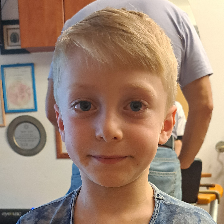

In [4]:
filename = "nadavCLIP.jpg"


tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
])

img_pil = Image.open(f"/content/myfolder/{filename}")
import torchvision
img_u = TF.pil_to_tensor(img_pil)
target_img = img_u.float().div(255).mul(2).sub(1).unsqueeze(0).to(device)
display(TF.to_pil_image(tf(target_img)[0]))


# Part 2 (Understanding how to use the generator)

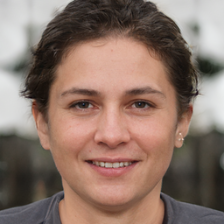

In [5]:
# So let's sample from the style space
zs = torch.randn([10000, G.mapping.z_dim], device=device) #random of size 10000 & space dimension size
cs = torch.zeros([10000, G.mapping.c_dim], device=device)
w_avg = G.mapping(zs, cs).mean(0).unsqueeze(0) #mapping moves random latent to intermediate latent space. from there we synthesize LITAL

image = G.synthesis(w_avg, noise_mode='const')
display(TF.to_pil_image(tf(image)[0]))

# Part 3 (GAN Inversion) using lpips loss





In [7]:
loss_fn_vgg(tf(image)[0], tf(target_img)[0] )

tensor([[[[0.5476]]]], device='cuda:0', grad_fn=<AddBackward0>)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/1000 [00:00<?, ?it/s]

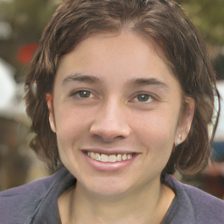

Image 0/1000 | Current loss: tensor([[[[0.6101]]]], device='cuda:0', grad_fn=<AddBackward0>)


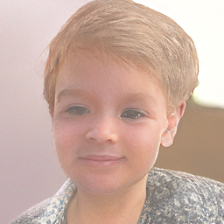

Image 10/1000 | Current loss: tensor([[[[0.4706]]]], device='cuda:0', grad_fn=<AddBackward0>)


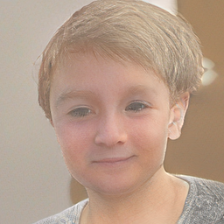

Image 20/1000 | Current loss: tensor([[[[0.4577]]]], device='cuda:0', grad_fn=<AddBackward0>)


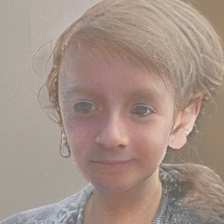

Image 30/1000 | Current loss: tensor([[[[0.4416]]]], device='cuda:0', grad_fn=<AddBackward0>)


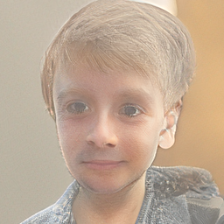

Image 40/1000 | Current loss: tensor([[[[0.4449]]]], device='cuda:0', grad_fn=<AddBackward0>)


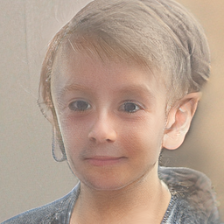

Image 50/1000 | Current loss: tensor([[[[0.3862]]]], device='cuda:0', grad_fn=<AddBackward0>)


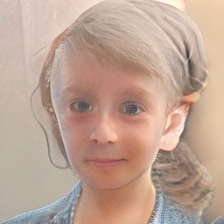

Image 60/1000 | Current loss: tensor([[[[0.3636]]]], device='cuda:0', grad_fn=<AddBackward0>)


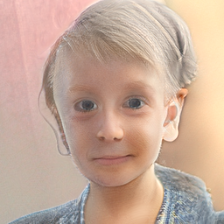

Image 70/1000 | Current loss: tensor([[[[0.3881]]]], device='cuda:0', grad_fn=<AddBackward0>)


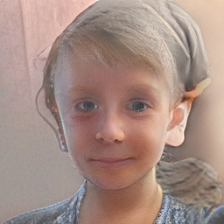

Image 80/1000 | Current loss: tensor([[[[0.3539]]]], device='cuda:0', grad_fn=<AddBackward0>)


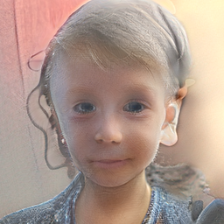

Image 90/1000 | Current loss: tensor([[[[0.3739]]]], device='cuda:0', grad_fn=<AddBackward0>)


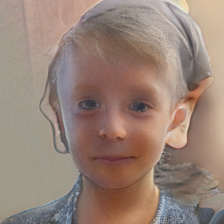

Image 100/1000 | Current loss: tensor([[[[0.3448]]]], device='cuda:0', grad_fn=<AddBackward0>)


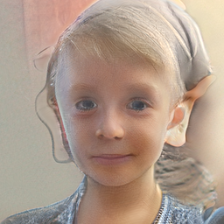

Image 110/1000 | Current loss: tensor([[[[0.3219]]]], device='cuda:0', grad_fn=<AddBackward0>)


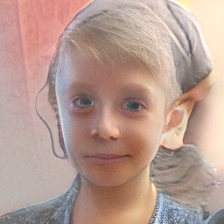

Image 120/1000 | Current loss: tensor([[[[0.3167]]]], device='cuda:0', grad_fn=<AddBackward0>)


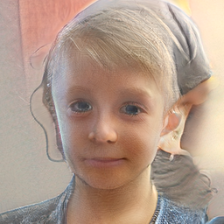

Image 130/1000 | Current loss: tensor([[[[0.3173]]]], device='cuda:0', grad_fn=<AddBackward0>)


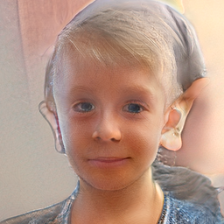

Image 140/1000 | Current loss: tensor([[[[0.3140]]]], device='cuda:0', grad_fn=<AddBackward0>)


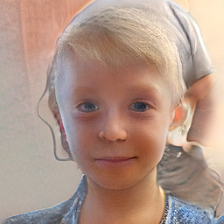

Image 150/1000 | Current loss: tensor([[[[0.3205]]]], device='cuda:0', grad_fn=<AddBackward0>)


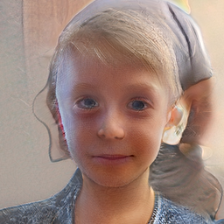

Image 160/1000 | Current loss: tensor([[[[0.2959]]]], device='cuda:0', grad_fn=<AddBackward0>)


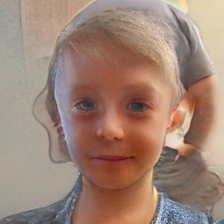

Image 170/1000 | Current loss: tensor([[[[0.2936]]]], device='cuda:0', grad_fn=<AddBackward0>)


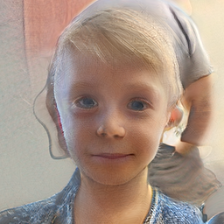

Image 180/1000 | Current loss: tensor([[[[0.2804]]]], device='cuda:0', grad_fn=<AddBackward0>)


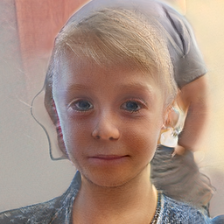

Image 190/1000 | Current loss: tensor([[[[0.2809]]]], device='cuda:0', grad_fn=<AddBackward0>)


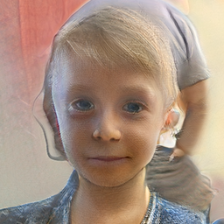

Image 200/1000 | Current loss: tensor([[[[0.2973]]]], device='cuda:0', grad_fn=<AddBackward0>)


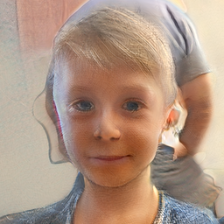

Image 210/1000 | Current loss: tensor([[[[0.2699]]]], device='cuda:0', grad_fn=<AddBackward0>)


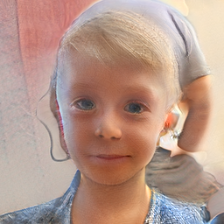

Image 220/1000 | Current loss: tensor([[[[0.2883]]]], device='cuda:0', grad_fn=<AddBackward0>)


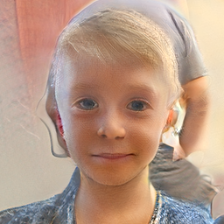

Image 230/1000 | Current loss: tensor([[[[0.2751]]]], device='cuda:0', grad_fn=<AddBackward0>)


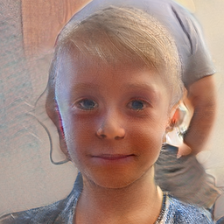

Image 240/1000 | Current loss: tensor([[[[0.2825]]]], device='cuda:0', grad_fn=<AddBackward0>)


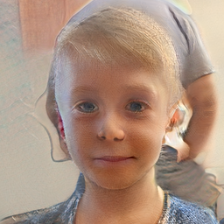

Image 250/1000 | Current loss: tensor([[[[0.2643]]]], device='cuda:0', grad_fn=<AddBackward0>)


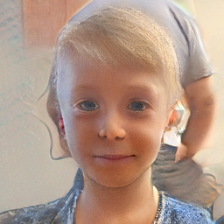

Image 260/1000 | Current loss: tensor([[[[0.2496]]]], device='cuda:0', grad_fn=<AddBackward0>)


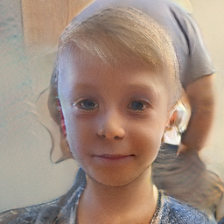

Image 270/1000 | Current loss: tensor([[[[0.2753]]]], device='cuda:0', grad_fn=<AddBackward0>)


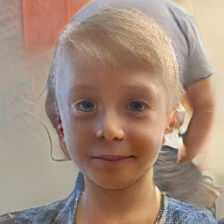

Image 280/1000 | Current loss: tensor([[[[0.2492]]]], device='cuda:0', grad_fn=<AddBackward0>)


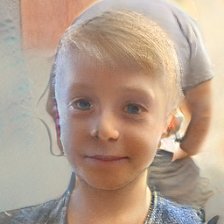

Image 290/1000 | Current loss: tensor([[[[0.2780]]]], device='cuda:0', grad_fn=<AddBackward0>)


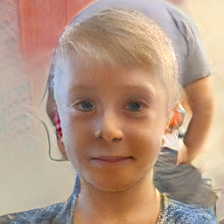

Image 300/1000 | Current loss: tensor([[[[0.2565]]]], device='cuda:0', grad_fn=<AddBackward0>)


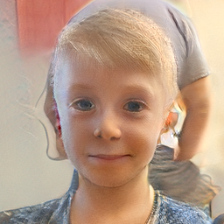

Image 310/1000 | Current loss: tensor([[[[0.2436]]]], device='cuda:0', grad_fn=<AddBackward0>)


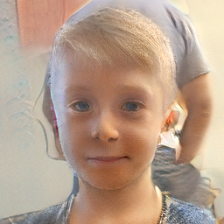

Image 320/1000 | Current loss: tensor([[[[0.2596]]]], device='cuda:0', grad_fn=<AddBackward0>)


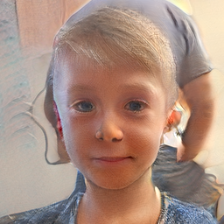

Image 330/1000 | Current loss: tensor([[[[0.2493]]]], device='cuda:0', grad_fn=<AddBackward0>)


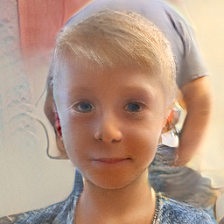

Image 340/1000 | Current loss: tensor([[[[0.2414]]]], device='cuda:0', grad_fn=<AddBackward0>)


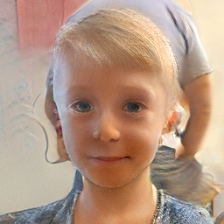

Image 350/1000 | Current loss: tensor([[[[0.2295]]]], device='cuda:0', grad_fn=<AddBackward0>)


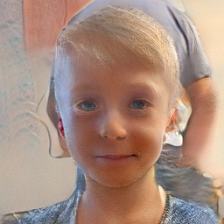

Image 360/1000 | Current loss: tensor([[[[0.2760]]]], device='cuda:0', grad_fn=<AddBackward0>)


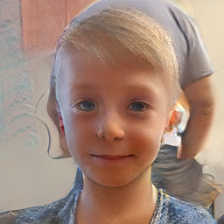

Image 370/1000 | Current loss: tensor([[[[0.2266]]]], device='cuda:0', grad_fn=<AddBackward0>)


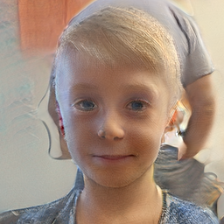

Image 380/1000 | Current loss: tensor([[[[0.2416]]]], device='cuda:0', grad_fn=<AddBackward0>)


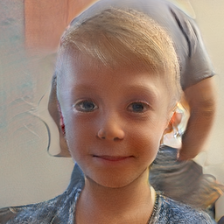

Image 390/1000 | Current loss: tensor([[[[0.2408]]]], device='cuda:0', grad_fn=<AddBackward0>)


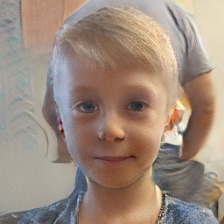

Image 400/1000 | Current loss: tensor([[[[0.2440]]]], device='cuda:0', grad_fn=<AddBackward0>)


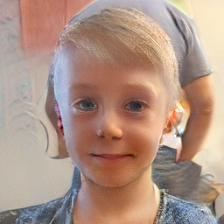

Image 410/1000 | Current loss: tensor([[[[0.2165]]]], device='cuda:0', grad_fn=<AddBackward0>)


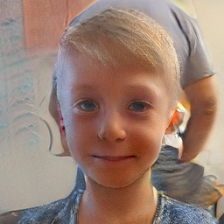

Image 420/1000 | Current loss: tensor([[[[0.2437]]]], device='cuda:0', grad_fn=<AddBackward0>)


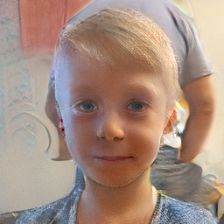

Image 430/1000 | Current loss: tensor([[[[0.2093]]]], device='cuda:0', grad_fn=<AddBackward0>)


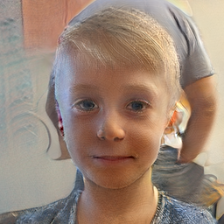

Image 440/1000 | Current loss: tensor([[[[0.2215]]]], device='cuda:0', grad_fn=<AddBackward0>)


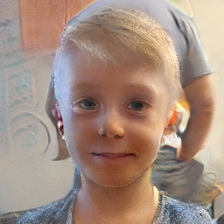

Image 450/1000 | Current loss: tensor([[[[0.2224]]]], device='cuda:0', grad_fn=<AddBackward0>)


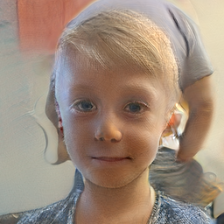

Image 460/1000 | Current loss: tensor([[[[0.2375]]]], device='cuda:0', grad_fn=<AddBackward0>)


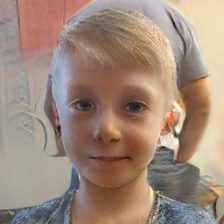

Image 470/1000 | Current loss: tensor([[[[0.2168]]]], device='cuda:0', grad_fn=<AddBackward0>)


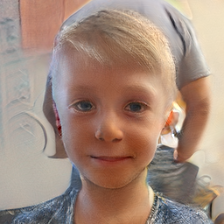

Image 480/1000 | Current loss: tensor([[[[0.2087]]]], device='cuda:0', grad_fn=<AddBackward0>)


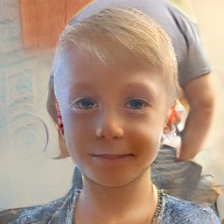

Image 490/1000 | Current loss: tensor([[[[0.2244]]]], device='cuda:0', grad_fn=<AddBackward0>)


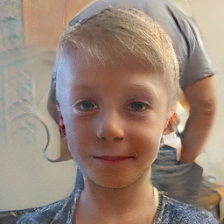

Image 500/1000 | Current loss: tensor([[[[0.2289]]]], device='cuda:0', grad_fn=<AddBackward0>)


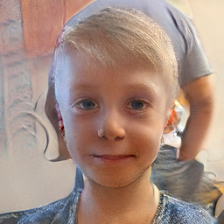

Image 510/1000 | Current loss: tensor([[[[0.2168]]]], device='cuda:0', grad_fn=<AddBackward0>)


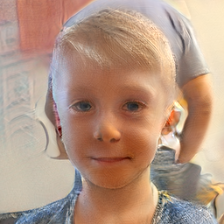

Image 520/1000 | Current loss: tensor([[[[0.2093]]]], device='cuda:0', grad_fn=<AddBackward0>)


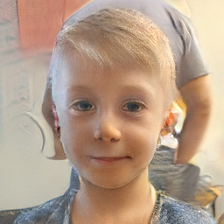

Image 530/1000 | Current loss: tensor([[[[0.2136]]]], device='cuda:0', grad_fn=<AddBackward0>)


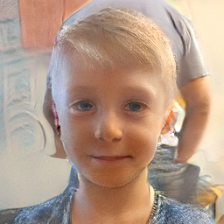

Image 540/1000 | Current loss: tensor([[[[0.2038]]]], device='cuda:0', grad_fn=<AddBackward0>)


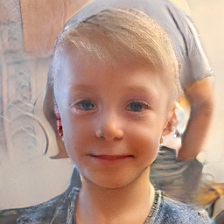

Image 550/1000 | Current loss: tensor([[[[0.2317]]]], device='cuda:0', grad_fn=<AddBackward0>)


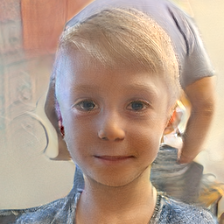

Image 560/1000 | Current loss: tensor([[[[0.2047]]]], device='cuda:0', grad_fn=<AddBackward0>)


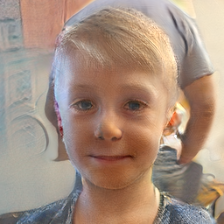

Image 570/1000 | Current loss: tensor([[[[0.1992]]]], device='cuda:0', grad_fn=<AddBackward0>)


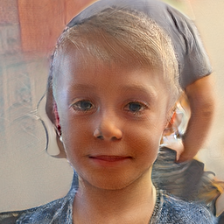

Image 580/1000 | Current loss: tensor([[[[0.2241]]]], device='cuda:0', grad_fn=<AddBackward0>)


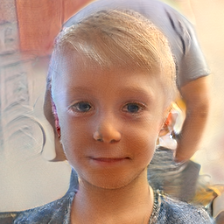

Image 590/1000 | Current loss: tensor([[[[0.2190]]]], device='cuda:0', grad_fn=<AddBackward0>)


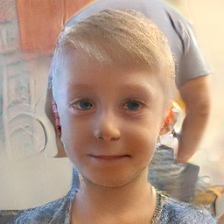

Image 600/1000 | Current loss: tensor([[[[0.2032]]]], device='cuda:0', grad_fn=<AddBackward0>)


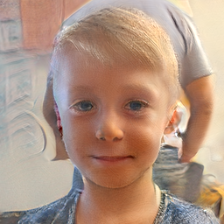

Image 610/1000 | Current loss: tensor([[[[0.2011]]]], device='cuda:0', grad_fn=<AddBackward0>)


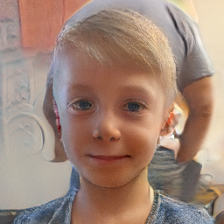

Image 620/1000 | Current loss: tensor([[[[0.1964]]]], device='cuda:0', grad_fn=<AddBackward0>)


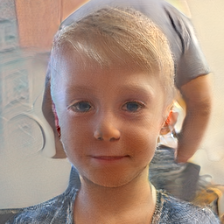

Image 630/1000 | Current loss: tensor([[[[0.2075]]]], device='cuda:0', grad_fn=<AddBackward0>)


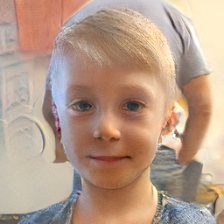

Image 640/1000 | Current loss: tensor([[[[0.2023]]]], device='cuda:0', grad_fn=<AddBackward0>)


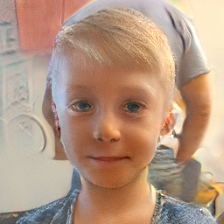

Image 650/1000 | Current loss: tensor([[[[0.1965]]]], device='cuda:0', grad_fn=<AddBackward0>)


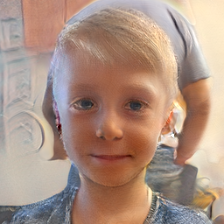

Image 660/1000 | Current loss: tensor([[[[0.2095]]]], device='cuda:0', grad_fn=<AddBackward0>)


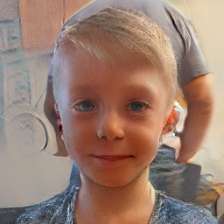

Image 670/1000 | Current loss: tensor([[[[0.2008]]]], device='cuda:0', grad_fn=<AddBackward0>)


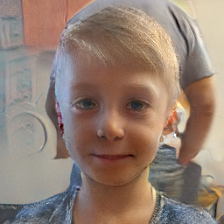

Image 680/1000 | Current loss: tensor([[[[0.2010]]]], device='cuda:0', grad_fn=<AddBackward0>)


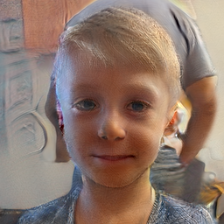

Image 690/1000 | Current loss: tensor([[[[0.2101]]]], device='cuda:0', grad_fn=<AddBackward0>)


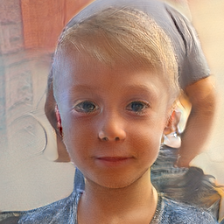

Image 700/1000 | Current loss: tensor([[[[0.2230]]]], device='cuda:0', grad_fn=<AddBackward0>)


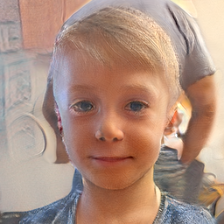

Image 710/1000 | Current loss: tensor([[[[0.2086]]]], device='cuda:0', grad_fn=<AddBackward0>)


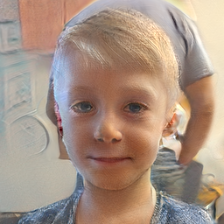

In [ ]:
# Here you will try to invert the image that you uploaded.

# Let's load LPIPS
import lpips
loss_fn_vgg = lpips.LPIPS(net='vgg').to(device)

# Initializing the noise to be added like above (this is the only thing that should be optimized if you don't want to go too far)
z = torch.randn(1, 18, 512, device=device).requires_grad_()
# Setting optimizer, steps
opt = torch.optim.AdamW([z], lr=0.1, betas=(0., 0.999))#, weight_decay=0.025)
steps = 1000
loop = tqdm(range(steps))

# Main loop (for solving min_{z}||G(z)-I||)
for i in loop:

  # This will generate an image from the latent variable z
  image = G.synthesis(w_avg + z, noise_mode='const')

  # Here you should write your loss functions
  #### ENTER YOUR CODE HERE (you should implement "loss" variable) #############
  loss =  loss_fn_vgg(tf(image)[0], tf(target_img)[0] )

  ######################################


  # The rest of the optimization (backward plus some print functions)
  opt.zero_grad()
  loss.backward()
  opt.step()
  loop.set_postfix(loss=loss.item())
  if i % 10 == 0 or i == (steps - 1):
    display(TF.to_pil_image(tf(image)[0]))
    print(f"Image {i}/{steps} | Current loss: {loss}")


# Part 4 (GAN Image Manipulation)

Here you can take the latent vector that your found in the previous section, and try to manipulate it with text (CLIP) guidance.

You may want to change one part here (which is how you feed the latent to the generator, like we did in the previous sections).

Your random seed is: 3020542788


  0%|          | 0/100 [00:00<?, ?it/s]

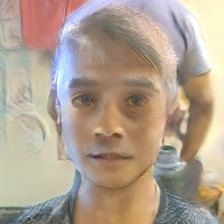

Image 0/100 | Current loss: 0.710241973400116


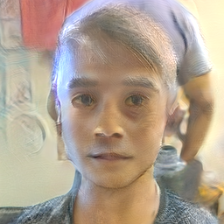

Image 10/100 | Current loss: 0.7072129249572754


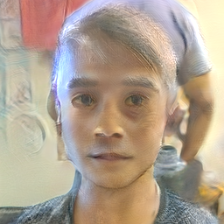

Image 20/100 | Current loss: 0.7009711861610413


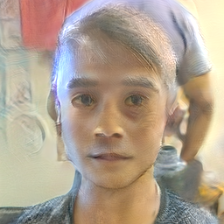

Image 30/100 | Current loss: 0.7000632286071777


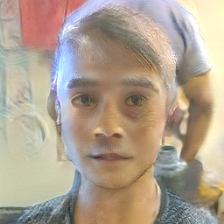

Image 40/100 | Current loss: 0.6927047967910767


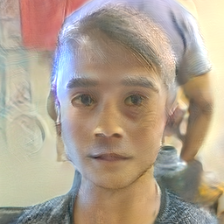

Image 50/100 | Current loss: 0.6860655546188354


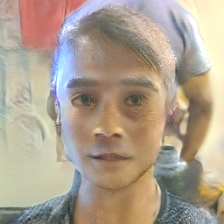

Image 60/100 | Current loss: 0.6798831224441528


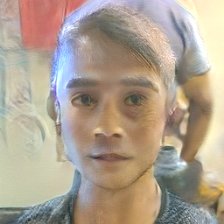

Image 70/100 | Current loss: 0.6765820980072021


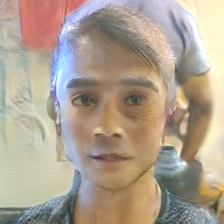

Image 80/100 | Current loss: 0.6742777228355408


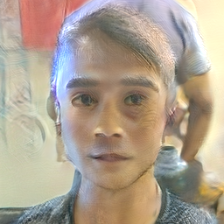

Image 90/100 | Current loss: 0.6731138825416565


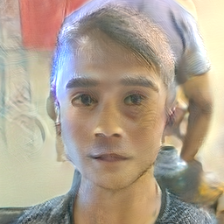

Image 99/100 | Current loss: 0.6722469329833984


In [10]:
texts = "Male 25 years old"#@param {type:"string"}
steps = 100#@param {type:"number"}
seed = -1#@param {type:"number"}

#@markdown ---

if seed == -1:
    seed = np.random.randint(0,9e9)
    print(f"Your random seed is: {seed}")

texts = [frase.strip() for frase in texts.split("|") if frase]

targets = [clip_model.embed_text(text) for text in texts]


q=z.detach().data
q.requires_grad_(True)
q_ema = q
opt = torch.optim.AdamW([q], lr=0.01, betas=(0., 0.999))#, weight_decay=0.025)
loop = tqdm(range(steps))
for i in loop:
  opt.zero_grad()
  image = G.synthesis(w_avg + q, noise_mode='const')
  embed = embed_image(image.add(1).div(2))
  loss = prompts_dist_loss(embed, targets, spherical_dist_loss).mean()
  loss.backward()
  opt.step()
  loop.set_postfix(loss=loss.item(), q_magnitude=q.std().item())

  q_ema = q_ema * 0.95 + q * 0.05
  image = G.synthesis(w_avg + q_ema, noise_mode='const')

  if i % 10 == 0 or i == (steps - 1):
    display(TF.to_pil_image(tf(image)[0]))
    print(f"Image {i}/{steps} | Current loss: {loss}")
  pil_image = TF.to_pil_image(image[0].add(1).div(2).clamp(0,1))
